In [989]:
import pandas as pd
import os
from tqdm import tqdm_notebook, tnrange
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from scipy.optimize import minimize
from scipy.sparse import csr_matrix, vstack, hstack

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import cvxpy as cp
import pickle, json

module_path = os.path.abspath(os.path.join('..'))

%matplotlib inline

In [990]:
#load in data for prototyping
protein_df_PD1_test = pd.read_csv(module_path+'/data/harel/protein_df_PD1_test_feats_new.csv', index_col=0)
protein_df_PD1_train = pd.read_csv(module_path+'/data/harel/protein_df_PD1_train_feats.csv', index_col=0)
proteins_df = pd.read_csv(module_path+'/data/harel/protein_df_PD1.csv', index_col=0)
protein_list = list(set(list(proteins_df["Gene_Names"])))
interactome_protein_set = set(np.loadtxt(module_path+
                            '/data/interactome/proteins_in_interactome.txt',
                            dtype=str))

response_df = response_df = pd.read_csv(module_path+'/data/harel/response_df.csv', index_col=0)
test_ids = protein_df_PD1_test.index.tolist()
test_PFS = []
for i in test_ids:
    test_PFS.append(response_df[response_df['Sample ID'] == i]['PFS time (months)'].values[0])
y_test_raw = pd.DataFrame({'Patient_ID': test_ids, 'PFS': test_PFS})

In [991]:
proteins_df

protein_df_test = pd.DataFrame()
for i in test_ids:
    protein_df_test[i] = proteins_df[i]
    
protein_df_test['Gene_Names'] = proteins_df['Gene_Names']

In [992]:
y_train_raw = pd.read_csv(module_path+'/data/harel/protein_df_PD1_train_PFS.csv', index_col=0)
y_train = y_train_raw['PFS'].tolist()
y_train = np.array(y_train).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(y_train)
y_train = scaler.transform(y_train).reshape(-1)
del scaler
#y_test_raw = pd.read_csv(module_path+'/data/harel/protein_df_PD1_test_PFS.csv', index_col=0)
y_test = y_test_raw['PFS'].tolist()
y_test = np.array(y_test).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(y_test)
y_test = scaler.transform(y_test.reshape(-1,1)).reshape(-1)

In [993]:
protein_df_PD1_train.columns

Index(['PD1_32', 'PD1_71', 'PD1_65', 'PD1_47', 'PD1_54', 'PD1_83', 'PD1_25',
       'PD1_5', 'PD1_6', 'PD1_75', 'PD1_16', 'PD1_70', 'PD1_57', 'PD1_44',
       'PD1_62', 'PD1_64', 'PD1_28', 'PD1_73', 'PD1_38', 'PD1_55', 'PD1_21',
       'PD1_68', 'PD1_12', 'PD1_26', 'PD1_53', 'PD1_17', 'PD1_72', 'PD1_15',
       'PD1_50', 'PD1_80', 'PD1_69', 'PD1_61', 'PD1_85', 'PD1_24', 'PD1_4',
       'PD1_56', 'PD1_39', 'PD1_63', 'PD1_36', 'PD1_76', 'PD1_8', 'PD1_2',
       'PD1_46', 'PD1_82', 'PD1_78', 'PD1_51', 'PD1_43', 'PD1_59', 'PD1_81',
       'PD1_10', 'PD1_67', 'PD1_30', 'PD1_11', 'PD1_33', 'PD1_29', 'PD1_74',
       'PD1_84', 'PD1_23', 'PD1_66', 'Gene_Names'],
      dtype='object')

In [994]:
sum(y_train_raw['PFS'])

672.2700000000001

In [995]:
#print(y_train)
print(sum(y_train))
max(y_train)


-8.659739592076221e-15


3.1530918094102867

In [996]:
g = nx.read_edgelist(module_path+"/data/interactome/inbiomap_reduced.txt", 
                     data=(('confidence',float),))

In [997]:
a = list(interactome_protein_set)
b = protein_list

In [998]:
##### IMPORT MODULES #####
import pandas as pd
import os
from tqdm import tqdm_notebook, tnrange
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from scipy.optimize import minimize
from scipy.sparse import csr_matrix, vstack, hstack

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import cvxpy as cp

import pickle

from joblib import Parallel, delayed

module_path = os.path.abspath(os.path.join('..'))

%matplotlib inline


##### PIPELINE #####

class LinearRegression:

    def __init__ (self,):
        self.intersection_proteins = set()
        self.connected_proteins = set()
        self.orphan_proteins = set()
        self.graph = None
        self.ordered_protein_names = []
        self.ordered_in_interactome_bool = []
        self.ordered_protein_names_connected = []
        self.L = None
        self.A = None
        self.selected_features = []
        self.regr = None
        self.alpha = None
        self.split_num = None
        #delete
        self.X_train = None
        self.reg = None
        
    def preliminary_analysis(self,path):
        self.graph = self.getGraph(path)
        print('SHOW GRAPHS')
        

    def fit(self, X_train, y_train, data_protein, interactome_protein, alpha, split_num, coef_threshold = 0.001, 
            max_features = 10, method = 'vanilla', preset = None):   
        '''
        Parameters:
        -----------
        
        X_train: see example file 
        
        y_train: array-like, list of responses 
        
        data_protein : array-like, list of proteins/nodes found in train data
        
        interactome_protein : array-like, list of proteins/nodes found in interactome 
        
        alpha : float, for regularization strength
        
        split_num : int, to serialize the split if using cross validation (can ignore for now and just put in any number)
        
        coef_threshold : float, threshold for feature coeffiencient in order to be selected
        
        max_features : int, max number of features selected
        
        method : str, 'vanilla' or 'laplacian'
        
        preset : if you have a laplacian already calculated... 
        
        Returns:
        --------
        
        
        '''
        
        
        #save signature
        self.alpha = alpha
        self.split_num = split_num
        
        self.data_protein = data_protein
        self.interactome_protein = interactome_protein
        self.graph = self.getGraph(path)
        
        self.preprocessing(self.data_protein, self.interactome_protein)
        X = self.getSortData(X_train, self.connected_proteins)
        X = X.values
        self.X_train = deepcopy(X)
        
        if method == 'vanilla':
            reg = self.getVanilla(self.orphan_proteins, self.connected_proteins,)
            
        if method == 'laplacian':
            if preset is not None:
                L, reg = preset
            else:
                L,reg = self.getLaplacian(self, self.graph, self.ordered_protein_names_connected)
        
        self.reg = reg
        
        self.A = self.getOptimization(self.orphan_proteins, self.connected_proteins, self.X_train, y_train, reg, alpha)
        
        np.save('A_' + str(split_num) + '_' + str(alpha) + '.npy', self.A)
        
        sorted_features = np.argsort(-abs(self.A))[:max_features]
        
        self.selected_features.append([i for i in sorted_features if np.abs(self.A[i])> coef_threshold])
        
        if not self.selected_features[0]:
            pass
        else:
            self.regr = self.getFittedRegression(self.X_train[:,self.selected_features[0]], y_train)
        
        
    
    def predict(self, X_test, y_test):
        if not self.selected_features[0]:
            y_pred = np.mean(y_test) * np.ones(y_test.shape)
        else:
            X_test = self.getSortData(X_test, self.connected_proteins).values
            X_test = X_test[:,self.selected_features[0]] #FLAG
            y_pred = self.regr.predict(X_test)
        return y_pred
        
        
    def preprocessing(self, data_protein, interactome_protein):
        self.intersection_proteins = self.getUnion(self.data_protein, self.interactome_protein)
        self.connected_proteins, self.orphan_proteins = self.getConnectedProteins(self.graph, self.data_protein)
                
        
    def getUnion(self, data_protein, interactome_protein):
        '''
        Gets the union of proteins in dataset and interactome
        '''
        intersection_proteins = set()
        for protein in tqdm_notebook(data_protein):
            if protein in interactome_protein:
                intersection_proteins.add(protein)
    
        return intersection_proteins
    
    def getGraph(self, path):
        g = nx.read_edgelist(path, data=(('confidence',float),))
        return g
    
    def getConnectedProteins(self, g, data_protein,):
        connected_proteins = set(g.nodes())
        orphan_proteins = set(data_protein) - connected_proteins
        return connected_proteins, orphan_proteins
    
    def getSortData(self, data, connected_proteins):
        data['In_Interactome'] = list(data["Gene_Names"].isin(list(connected_proteins)))
        data = data.sort_values(by = 'In_Interactome', ascending = False).reset_index(drop = True)
        self.ordered_protein_names = data['Gene_Names'].tolist()
        self.ordered_protein_names_connected = data[data['In_Interactome'] == True]['Gene_Names'].tolist()
        self.ordered_in_interactome_bool = data['In_Interactome']
        
        data = data.drop(columns = ['In_Interactome', 'Gene_Names'])
        
        data = data.T
        return data
    
    def getLaplacian(self, g, connected_nodelist, orphan_proteins):
        L = nx.normalized_laplacian_matrix(g,connected_nodelist, weight="confidence")
        Reg1 = csr_matrix(scipy.linalg.block_diag(L.todense(),np.eye(len(orphan_proteins))))
        return L, Reg1
        
    def getVanilla(self, orphan_proteins, connected_proteins):
        Reg0 = np.eye(len(orphan_proteins)+len(connected_proteins))
        return Reg0
    
    def getOptimization(self, orphan_proteins, connected_proteins, x, y, reg, alpha):
        A = cp.Variable(len(connected_proteins)+len(orphan_proteins))
        a = cp.Parameter(nonneg=True)
        a.value = alpha
        objective = cp.Minimize((1. / (2*x.shape[0])) * cp.sum_squares(x*A - y)+ a* cp.norm1(reg*A))
        prob = cp.Problem(objective)
        prob.solve()
        return A.value
    
    def getFittedRegression(self, X_train, y_train):
        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        return regr

In [1000]:
protein_df_PD1_train

,PD1_32,PD1_71,PD1_65,PD1_47,PD1_54,PD1_83,PD1_25,PD1_5,PD1_6,PD1_75,...,PD1_67,PD1_30,PD1_11,PD1_33,PD1_29,PD1_74,PD1_84,PD1_23,PD1_66,Gene_Names
0,-0.387716,0.191326,0.095295,0.088551,0.395559,0.584446,0.713407,0.192113,0.470746,0.727331,...,-0.133786,1.563249,-0.033333,-0.053899,0.134510,-0.369237,-0.044276,1.413123,2.279067,A2M
1,-0.169020,1.407079,-0.032778,-0.006320,-0.647169,-1.369788,0.378389,0.103819,-0.316775,0.447224,...,-0.843234,-0.784888,0.309622,1.198786,1.843529,0.488421,-1.647037,-1.048313,-0.625672,AAAS
2,-0.379373,-0.090895,0.242324,-1.560649,-0.824295,-0.904554,-0.432115,0.602818,0.044033,-0.896576,...,-1.122219,-0.585842,-1.758475,-1.529491,0.231833,0.653420,-0.304590,-1.781818,0.799285,AACS
3,-0.579154,-0.127509,0.068251,-0.158432,0.451031,-1.110854,0.241023,2.357473,-0.215351,0.958883,...,-1.150339,-0.026003,0.045140,0.161654,-0.945705,0.177708,-0.834980,-1.468132,-0.105052,AAK1
4,1.306824,-0.075431,1.668153,0.562577,-0.395250,1.725839,-0.359918,-0.690643,3.397513,0.549286,...,1.507734,-1.224487,-0.189870,-0.403252,1.246058,-1.224487,-0.037623,-0.442295,-0.984162,AAMDC
5,-0.766594,0.664806,-0.892606,-1.051960,0.637358,-0.219266,-1.519243,0.854281,-1.309446,-0.053634,...,0.203267,0.809958,-0.376756,-0.929880,0.115896,-2.157695,0.359063,-2.652272,-1.189227,AAMP
6,0.165296,0.453783,0.147217,-1.386137,-1.840791,1.024029,-0.859549,1.095474,-0.599875,-1.268874,...,0.147217,-0.065300,-0.183569,1.422425,0.368985,0.147217,-0.727883,-0.797219,0.644736,AAR2
7,0.779662,-0.293839,0.778607,-0.001495,-0.295590,-0.198422,0.034883,0.565848,0.987871,-0.588741,...,-1.539067,-1.357511,-1.229452,-1.201962,0.458628,-2.011618,0.417334,-0.784341,2.303743,AARS
8,-1.172261,-0.984937,1.475103,0.524538,0.948168,-1.617205,0.098524,-0.369783,-1.090596,0.100367,...,-0.515151,-1.423071,-0.394935,-0.190836,1.231587,-0.422671,-0.949168,0.720776,0.457344,AARS2
9,-1.198371,0.121666,0.496495,-1.102904,-0.831197,-0.290989,0.144075,-0.132409,-0.755142,-1.618960,...,0.091599,-1.263347,0.401312,-0.888632,1.013018,0.432235,1.761999,-0.713973,-0.295770,AASDHPPT


In [1003]:
vanilla_lasso_train_err = []
vanilla_lasso_test_err = []
for i in np.logspace(-1,0,3):
    asd = LinearRegression()
    path = module_path+"/data/interactome/inbiomap_reduced.txt"
    asd.fit(protein_df_PD1_train,y_train,b,a, alpha = i, split_num = 1)
    y_pred_test = asd.predict(protein_df_test, y_test)
    y_pred_train = asd.predict(protein_df_PD1_train, y_train)
    mse_train = mean_squared_error(y_train,y_pred_train)
    mse_test = mean_squared_error(y_test,y_pred_test)
    vanilla_lasso_train_err.append(mse_train)
    vanilla_lasso_test_err.append(mse_test)

In [1001]:
protein_df_PD1_train.to_csv('Example_X_train.csv')

In [1002]:
y_train.

array([-7.14046810e-01, -5.37336502e-01, -7.61852497e-01,  7.34636245e-01,
        6.02345870e-02,  3.13775463e-01,  2.90894134e+00, -2.08354084e-03,
        8.48174752e-01, -2.27453209e-01, -4.75018374e-01, -7.56730459e-01,
       -7.93438397e-01, -5.51848943e-01,  3.47922383e-01, -8.33561028e-01,
       -4.60505933e-01, -4.97213872e-01, -7.87462686e-01,  2.01119568e-02,
        1.29208470e+00, -1.55744678e-01,  2.99430863e+00,  9.39517761e-01,
       -3.60626194e-01,  1.65062736e+00, -4.83555104e-01,  1.21525413e+00,
       -8.89903445e-01, -1.42085910e-01, -5.80020151e-01, -4.60505933e-01,
       -2.18916479e-01,  3.15309181e+00,  1.47477072e+00,  2.13895724e-01,
       -8.61732236e-01, -8.67707947e-01, -9.12952615e-01, -9.27465056e-01,
        1.15293601e+00, -4.45993493e-01,  7.43172975e-01, -5.82581170e-01,
       -7.22583540e-01,  2.39505914e-01, -8.13072876e-01,  6.12561008e-01,
       -7.22583540e-01,  1.04451954e+00, -6.56850720e-01, -8.70268966e-01,
       -7.14046810e-01, -

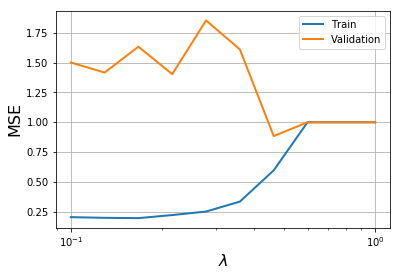

In [852]:
plt.plot(np.logspace(-1,0,10), vanilla_lasso_train_err, label="Train", linewidth=2)
plt.plot(np.logspace(-1,0,10), vanilla_lasso_test_err, label="Validation",linewidth=2)
plt.legend()
plt.grid()
plt.xscale('log')
plt.ylabel("MSE",fontsize=16)
plt.xlabel(r"$\lambda$",fontsize=16)
min_val = np.argmin(vanilla_lasso_test_err)

In [922]:
alpha_list = np.logspace(-1,0,10)

In [975]:
from copy import deepcopy
all_proteins_df = deepcopy(proteins_df)
PD1_ids = all_proteins_df.columns.tolist()
names = all_proteins_df['Gene_Names'].tolist()
all_proteins_df = all_proteins_df.drop(columns = ['Gene_Names'])
all_proteins_df = all_proteins_df.T
all_proteins_df = all_proteins_df.reset_index()


PD1_ids = [i for i in PD1_ids if 'PD1' in i]
all_response = []
for i in PD1_ids:
    all_response.append(response_df[response_df['Sample ID'] == i]['PFS time (months)'].values[0])
    
del scaler
scaler = StandardScaler()
all_response = np.array(all_response).reshape(-1,1)
scaler.fit(all_response)
all_response = scaler.transform(all_response.reshape(-1,1)).reshape(-1)
all_response = pd.DataFrame({'Sample ID':PD1_ids, 'PFS':all_response})

In [976]:
X_train_list[0].shape

(4249, 38)

In [977]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, random_state=1)
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []


for train_index, test_index in kf.split(all_proteins_df):
    X_train, X_test = all_proteins_df.loc[train_index], all_proteins_df.loc[test_index]
    y_train, y_test = all_response.loc[train_index], all_response.loc[test_index]
    
    X_train = X_train.set_index('index')
    X_train = X_train.T
    X_train['Gene_Names'] = names
    
    X_test = X_test.set_index('index')
    X_test = X_test.T
    X_test['Gene_Names'] = names    
    
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train['PFS'])
    y_test_list.append(y_test['PFS'])

In [978]:
import itertools
split_list = range(len(X_train_list))
alpha_list = alpha_list

iter_list = list(itertools.product(split_list,alpha_list))


In [979]:
def run(alpha, split_num, X_train, y_train, data_names, interactome_names, iter_num):
    model = LinearRegression()
    path = module_path+"/data/interactome/inbiomap_reduced.txt"
    model.fit(X_train,y_train,data_names,interactome_names, alpha = alpha, split_num = split_num)
    with open('model_iter_' + str(iter_num) + '.pkl', 'wb') as f:
        pickle.dump(model,f)


In [983]:
from joblib import Parallel, delayed
Parallel(n_jobs=3, verbose = True)(delayed(run(
    alpha = iter_list[i][1],
    split_num = iter_list[i][0],
    X_train = deepcopy(X_train_list[iter_list[i][0]]),
    y_train = deepcopy(y_train_list[iter_list[i][0]]),
    data_names = b,
    interactome_names = a,
    iter_num = i)
) for i in range(len(iter_list)))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.



A (4249,)



A (4249,)



A (4249,)



A (4249,)



A (4249,)



A (4249,)



A (4249,)



A (4249,)



A (4249,)



A (4249,)



A (4249,)



A (4249,)



A (4249,)


TypeError: cannot unpack non-iterable function object

In [982]:
iter_num

NameError: name 'iter_num' is not defined

In [942]:
y_train_list

[38    0.562662
 39    2.508737
 40   -0.797383
 41    0.770436
 42    2.376310
 43   -0.107086
 44   -0.142856
 45    0.029908
 46   -0.868163
 47    0.385331
 48   -0.789772
 49   -0.571343
 50    0.149397
 51   -0.934377
 52   -0.903934
 53   -0.840003
 54   -0.611680
 55   -0.746391
 56   -0.299638
 57   -0.677894
 58   -0.835437
 59   -0.639840
 60   -0.591892
 61   -0.604069
 62   -0.888712
 63   -0.363569
 64   -0.987652
 65   -0.782161
 66   -0.804993
 67   -0.343020
 68   -0.287461
 69   -0.804993
 70   -0.680177
 71    0.118954
 72   -0.515784
 73   -0.355958
 74         NaN
 Name: PFS, dtype: float64, 0     1.506398
 1     0.867093
 2     0.671496
 3     0.595389
 4    -0.482297
 5     0.052741
 6    -0.954165
 7    -0.162644
 8    -0.974714
 9    -0.862835
 10   -0.929049
 11    1.154019
 12   -0.967103
 13   -0.885668
 14   -0.652778
 15   -0.761612
 16    0.501776
 17    0.494165
 18    0.427952
 19   -0.797383
 20   -0.995263
 21   -0.936660
 22   -0.797383
 23   -0.5713